<a href="https://colab.research.google.com/github/OneRealUni/Healthcare/blob/master/Test_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependency


In [0]:
import os
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import itertools

from itertools import product
from functools import partial

'\nimport numpy as np\nimport keras\nfrom keras import backend as K\nfrom keras.models import Sequential\nfrom keras.layers import Activation\nfrom keras.layers.core import Dense, Flatten\nfrom keras.optimizers import Adam\nfrom keras.metrics import categorical_crossentropy\nfrom keras.preprocessing.image import ImageDataGenerator\nfrom keras.layers.normalization import BatchNormalization\nfrom keras.layers.convolutional import *\nfrom sklearn.metrics import confusion_matrix\nimport itertools\nimport matplotlib.pyplot as plt\n%matplotlib inline\n'

## Dowan Load Data from Kaggle

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

In [0]:
train_path = 'chest_xray/train'
valid_path = 'chest_xray/val'
test_path = 'chest_xray/test'

In [0]:
print(len(train_path))
print(len(valid_path))
print(len(test_path))

16
14
15


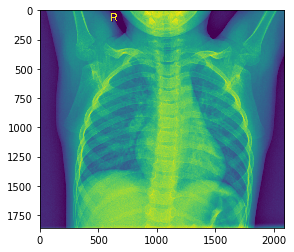

In [0]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)
      imgplot = plt.imshow(img, cmap='gray')

      amount += 1

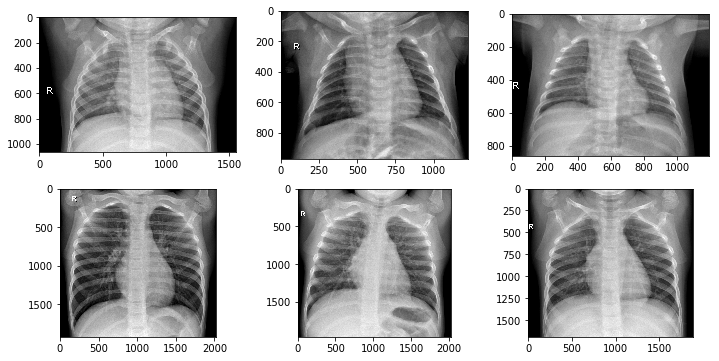

In [0]:
plot_images(training_dir + '/NORMAL')

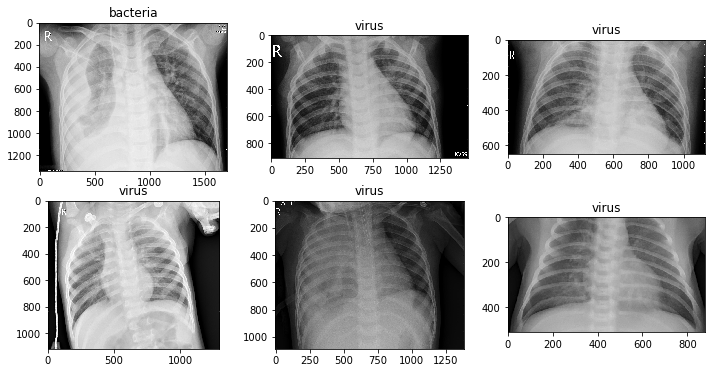

In [0]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

##  Build a pre-trained model using InceptionV3

In [0]:
K.clear_session()

NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  #base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

#IMG_SHAPE = (150, 150, 3)
model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

In [0]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 512) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32>]

In [0]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

##Feature optimisation

In [0]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the fine-tuned InceptionV3 model with new class labels

In [0]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=5,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
32/32 [==============================] - 226s 7s/step - loss: 0.5511 - acc: 0.7584 - val_loss: 0.9397 - val_acc: 0.6266
Epoch 2/5
32/32 [==============================] - 209s 7s/step - loss: 0.3857 - acc: 0.8351 - val_loss: 1.8397 - val_acc: 0.5176
Epoch 3/5
32/32 [==============================] - 205s 6s/step - loss: 0.3338 - acc: 0.8620 - val_loss: 1.1606 - val_acc: 0.6330
Epoch 4/5
32/32 [==============================] - 208s 6s/step - loss: 0.2784 - acc: 0.8884 - val_loss: 1.0622 - val_acc: 0.6971
Epoch 5/5
32/32 [==============================] - 210s 7s/step - loss: 0.2535 - acc: 0.8965 - val_loss: 1.1347 - val_acc: 0.6907


## Model saving

In [0]:
%mkdir -p '/content/drive/My Drive/ML_Course_Siraj/Week_04'
!mv {MODEL_FILE} '/content/drive/My Drive/ML_Course_Siraj/Week_04'

## Model performance visualization over the epochs

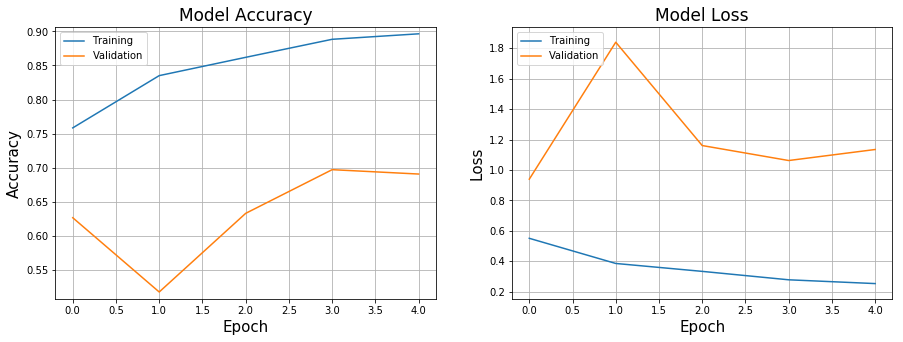

In [0]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Evaluate model

In [0]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 1s 669ms/step - loss: 1.3416 - acc: 0.6250
Loss     : 1.34  
Accuracy : 62.50%


In [0]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

1/1 [==============================] - 2s 2s/step


In [0]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 16
-----------------------------------
Accuracy                : 62.50%
-----------------------------------


## Predict using fine-tuned InceptionV3 model

In [0]:
test_generator.reset()
filenames = test_generator.filenames
#nb_samples = np.ceil(nb_samples/len(filenames))
#predict = model.predict_generator(test_generator, steps=nb_samples)
predict = model.predict_generator(test_generator)

In [0]:
import pandas as pd

predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

results

,Filename,Predictions
0,NORMAL/NORMAL2-IM-1427-0001.jpeg,NORMAL
1,NORMAL/NORMAL2-IM-1430-0001.jpeg,NORMAL
2,NORMAL/NORMAL2-IM-1431-0001.jpeg,NORMAL
3,NORMAL/NORMAL2-IM-1436-0001.jpeg,NORMAL
4,NORMAL/NORMAL2-IM-1437-0001.jpeg,PNEUMONIA
5,NORMAL/NORMAL2-IM-1438-0001.jpeg,PNEUMONIA
6,NORMAL/NORMAL2-IM-1440-0001.jpeg,NORMAL
7,NORMAL/NORMAL2-IM-1442-0001.jpeg,NORMAL
8,PNEUMONIA/person1946_bacteria_4874.jpeg,NORMAL
9,PNEUMONIA/person1946_bacteria_4875.jpeg,PNEUMONIA


## Confudion matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
#test_imgs, test_labels = next(test_batches)
test_imgs, test_labels = next(test_generator)

In [0]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [0]:
#predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions = model.predict_generator(test_generator, steps=1, verbose=0)

In [0]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[6 2]
 [3 5]]


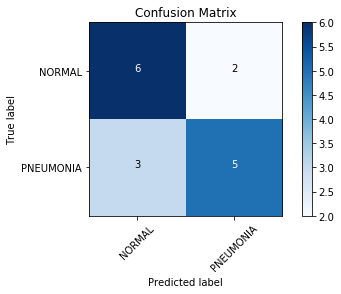

In [0]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Model saving and loading

In [0]:
model.save('pheumonia_model.h5')
new_model = keras.models.load_model('pheumonia_model.h5')